In [1]:
import math
import os
from shutil import copyfile

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
%matplotlib inline

# 1. Setting up file structure

In [3]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [4]:
def set_up_folders():
    
    os.rename('Dataset_A/data', 'data')
    
    for old_fname in listdir_fullpath('Dataset_A'):
        new_fname = os.path.join('data', old_fname.split('/')[-1])
        os.rename(old_fname, new_fname)

    os.rmdir('Dataset_A')
    
    for folder in ['train', 'val', 'test']:
        if folder not in os.listdir('data/'):
            os.mkdir(os.path.join('data/', folder))

            if folder in ['train', 'val']:
                os.mkdir(os.path.join('data/', folder, 'cancer'))
                os.mkdir(os.path.join('data/', folder, 'non_cancer'))

if 'Dataset_A' in os.listdir('.'):
    set_up_folders()

In [5]:
label_map = {'0': 'non_cancer', '1': 'cancer'}
added_lbl = []

def set_up_files():
    
    all_fnames = [x for x in os.listdir('data') if x.endswith('.png')]
    
    for folder in ['test', 'val', 'train']:                                  
        with open('data/{}.txt'.format(folder), 'r') as cur_file:            
            for line in cur_file:
                
                cur_prefx = line.split()[0]
                cur_fname = [x for x in all_fnames if x.startswith(cur_prefx)][0]
                cur_opath = os.path.join('data', cur_fname)
                
                if folder == 'test':
                    cur_dpath = os.path.join('data', folder, cur_fname)
                    os.rename(cur_opath, cur_dpath)
                    
                elif folder in ['val', 'train']:
                    if cur_prefx not in added_lbl:
                        cur_label = label_map[line.split()[1]]
                        cur_dpath = os.path.join('data', folder, cur_label, cur_fname)                    
                        os.rename(cur_opath, cur_dpath)
                    
                added_lbl.append(cur_prefx)
                    
if 'train' not in os.listdir('data'):
    set_up_files()

# 2. Data loading and preprocessing

In [6]:
classes = ('cancer', 'non_cancer')

In [7]:
train_pre_transform = transforms.Compose(
    [transforms.Grayscale(),
    transforms.ToTensor()])

trainset_pre = dset.ImageFolder(root="data/train/",transform=train_pre_transform)
trainloader_pre = torch.utils.data.DataLoader(trainset_pre, batch_size=1,shuffle=False, num_workers=2)

### 2.1 Normalizing 

In [8]:
c_avg = []
c_std = []

In [9]:
for i, data in enumerate(trainloader_pre):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    
    c_avg.append(inputs[0,0,:,:].mean().data[0])
    c_std.append(inputs[0,0,:,:].std().data[0])    

In [10]:
img_avgs = (np.mean(c_avg))
img_stds = (np.mean(c_std))

In [11]:
train_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((img_avgs,), (img_stds,))])

trainset = dset.ImageFolder(root="data/train/",transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=False, num_workers=2)

### 2.2 Data preview

cancer


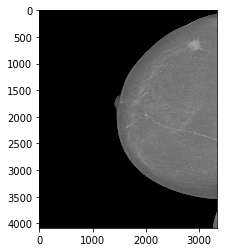

In [12]:
def imshow(img, img_set_avgs, img_set_stds):
    
    npimg = Variable(img).data[0].numpy()[0,:,:]    
    npimg = npimg * img_set_stds + img_set_avgs
    plt.imshow(npimg, cmap='gray')

dataiter = iter(trainloader)
image, labels = dataiter.next()

imshow(image, img_avgs, img_stds)
print(classes[labels[0]])

# 3. Looping through patches

In [13]:
all_images = []
all_labels = []

for i, data in enumerate(trainloader):
    inputs, labels = data
    inputs, labels = Variable(inputs), Variable(labels)
    inputs = inputs.data[0].numpy()[0,:,:]
    
    all_images.append(inputs)
    all_labels.append(labels)

In [14]:
def patch(image):
    
    """
    image = list of images, where each element is an image array
    returns: [all_images[image[image_patches]]]
    """
    
    height = 80
    width = 80
    
    images=[]
    for pic in image:
        row =int(math.floor(pic.shape[0]/height))
        col =int(math.floor(pic.shape[1]/width))
        patch_based_image = np.zeros(shape=(row,col,height,width))
        
        picture=[]
        for h in range(0,row):
            for w in range(0,col):
                current_grid = pic[h*height:(h+1)*height,w*width:(w+1)*width]
                picture.append(current_grid)
            
        picture=np.array(picture)
        
        images.append(picture)
        
    images=np.array(images)
    return images

In [15]:
patched_images = patch(all_images)